In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ls

In [ ]:
cd drive/

In [ ]:
ls

In [ ]:
cd My\ Drive

In [ ]:
ls

In [ ]:
cd Colab\ Notebooks

In [ ]:
import pandas as pd
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import scipy
import skimage
from skimage.transform import resize

In [ ]:
current_dir = os.getcwd()
DATASET = os.path.join(current_dir, "DR_GRADING_DATASET/")
TRAIN_DIR = os.path.join(DATASET, "Training_Set/")
TEST_DIR = os.path.join(DATASET, "Testing_Set/")

In [ ]:
print(os.listdir(DATASET))
print("")
print(os.listdir(TRAIN_DIR))
print("")
print(os.listdir(TEST_DIR))

In [ ]:
def get_data(Dir):
    X = []
    y = []
    
    for nextDir in os.listdir(Dir):
        if nextDir in ['A']:
            label = 0
        elif nextDir in ['B']:
            label = 1
        elif nextDir in ['C']:
            label = 2
        elif nextDir in ['D']:
            label = 3
        elif nextDir in ['E']:
            label = 4
        
        temp = Dir + nextDir
        
        for file in tqdm(os.listdir(temp)):
            img = cv2.imread(temp + '/' + file)
            if img is not None:
                img = np.asarray(img)
                X.append(img)
                y.append(label)
    
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y

In [ ]:
X_train, y_train = get_data(TRAIN_DIR)

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
y_train = to_categorical(y_train, 5)

In [ ]:
save1 = np.save(os.path.join(DATASET, "X_train.npy"), X_train)
save3 = np.save(os.path.join(DATASET, "y_train.npy"), y_train)

In [ ]:
X_test, y_test = get_data(TEST_DIR)

In [ ]:
print(X_train.shape, '\n', X_test.shape)

In [ ]:
print(y_train.shape, '\n', y_test.shape)

In [ ]:
y_test = to_categorical(y_test, 5)

In [ ]:
save2 = np.save(os.path.join(DATASET, "X_test.npy"), X_test)
save4 = np.save(os.path.join(DATASET, "y_test.npy"), y_test)

In [ ]:
# Lets load the saved npy file

In [ ]:
X_train = np.load(os.path.join(DATASET, 'X_train.npy'))
X_test = np.load(os.path.join(DATASET, 'X_test.npy'))
y_train = np.load(os.path.join(DATASET, 'y_train.npy'))
y_test = np.load(os.path.join(DATASET, 'y_test.npy'))

In [ ]:
print(y_test.shape)

In [ ]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [ ]:
filepath = os.path.join(DATASET, "DR_transfer_learning.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
X_train=X_train.reshape(9912,256,256,3)
X_test=X_test.reshape(2472,256,256,3)

In [ ]:
from keras.applications.inception_v3 import InceptionV3
# creating the base pre-trained model
base_model = InceptionV3(weights="imagenet", include_top=False , input_shape=(256, 256,3))














87916544/87910968 [==============================] - 8s 0us/step


In [ ]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(5, activation='softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
batch_size = 64
epochs = 10

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs, verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9912 samples, validate on 2472 samples
Epoch 1/10
9912/9912 [==============================] - 147s 15ms/step - loss: 0.8543 - acc: 0.6619 - val_loss: 2.0065 - val_acc: 0.4005

Epoch 00001: val_acc improved from -inf to 0.40049, saving model to /content/drive/My Drive/Colab Notebooks/DR_GRADING_DATASET/DR_transfer_learning.hdf5
Epoch 2/10
9912/9912 [==============================] - 123s 12ms/step - loss: 0.4586 - acc: 0.8262 - val_loss: 2.6331 - val_acc: 0.3604

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_acc did not improve from 0.40049
Epoch 3/10
9912/9912 [==============================] - 123s 12ms/step - loss: 0.1281 - acc: 0.9591 - val_loss: 1.7024 - val_acc: 0.5623

Epoch 00003: val_acc improved from 0.40049 to 0.56230, saving model to /content/drive/My Drive/Colab Notebooks/DR_GRADING_DATASET/DR_transfer_learning.hdf5
E

In [ ]:
# save_model = model.save() 

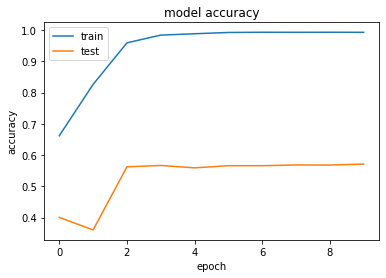

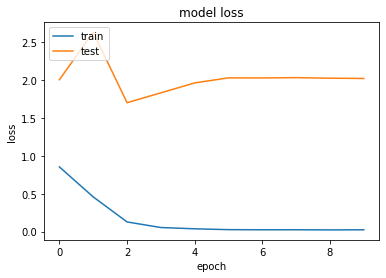

In [ ]:
import matplotlib.pyplot as plt
# Plotting training accuracy and validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Plotting validation loss and training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

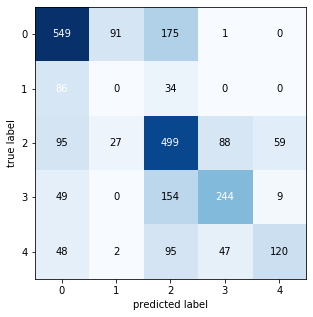

In [ ]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       816
           1       0.00      0.00      0.00       120
           2       0.52      0.65      0.58       768
           3       0.64      0.54      0.58       456
           4       0.64      0.38      0.48       312

    accuracy                           0.57      2472
   macro avg       0.49      0.45      0.46      2472
weighted avg       0.58      0.57      0.57      2472



In [ ]:
# DONE.